# Regression Models

Regression aims to estimate the world state $w$ for a given observations $\mathbf{x}$ by modeling $P(w|\mathbf{x})$ based on obtained data $\{\mathbf{x}_{i}, w_{i}\}_{i=1}^N$.

## Table of contents:
* [Maximum Likelihood Linear Regression](#ml-linear-regression)
* [Bayesian linear regression](#bayesian-linear-regression)
* [Non-linear regression - Maximum Likelihood](#non-linear-regression-ml)
* [Non-linear regression - Bayesian Inference](#non-linear-regression-bayes)
* [Kernels and Gaussian process regression](#kernel-gaussian-process-regression)
* [Sparse linear regression](#sparse-linear-regression)
* [Dual linear regression](#dual-linear-regression)
* [Relevance vector regression](#relevant-vector-regression)
* [Regression to multivariate data](#multivariate-data)

# Kernels and Gaussian process regression <a class="anchor" id="kernel-gaussian-process-regression"></a>

In [257]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spsp
import scipy.stats as spst
%matplotlib inline

# usual gangs

In [259]:
def generate_nice_params(ng, intvl):
    """
    Arguments:
        ng:    scalar. number of gaussians.
        intvl: scalar. distance between the means of gaussians.

    Output:
        lmd: scalar. std of the gaussians.
        wgt: weight distribution of the gaussians.  (ng+1, )
        sg:  scalar. noise rides on top of the generated curve.
    """
    lmd = intvl + (np.random.rand() - .5)
    wgt = 3 * np.random.rand(ng + 1) + .5
    sg = 0.2 * wgt.mean()
    wgt *= np.random.choice([-1, 1], ng + 1)
    wgt[0] = np.random.rand() - .5
    return lmd, wgt, sg


def generate_samples(ng, nx, ns, wgt, lmd, sg, x):
    """
    Arguments:
        ng:   scalar. number of gaussians.
        nx:   scalar. number of points between xlim (-10. and +10.) -> grid.
        ns:   scalar. number of samples
        wgt:  weight distribution of the gaussians.  (ng+1, )
        lmd:  scalar. std of the gaussians.
        sg:   scalar. noise rides on top of the generated curve.
        x:    x coodinates of the grid.
    
    Output:
        bases:     The basis gaussians on the grid. (ng+1 x nx) 1 for bias.
        bases_smp: The basis gaussians sampled from the grid. (ng x ns) 
        grdtr:     The generated curve. ground truth. (1, ng)
        cntrs:     The centers of the gaussians. (ng, )
        xs:        sampled x (ns, ) 
        smp:       sampled from grdtr added with sg noise, (ns, )
        
    """
    cntrs = np.arange(-lmd * (ng - 1) / 2, lmd * (ng + 1) / 2, lmd)
    bases = np.zeros((ng + 1, nx))
    bases[0, :] = np.ones(nx)
    for i in range(1, ng + 1, 1):
        bases[i, :] = spst.norm.pdf(x, cntrs[i - 1], 0.4 * lmd)
    grdtr = np.dot(wgt[np.newaxis, :], bases)
    idx = np.random.choice(np.arange(nx), ns, replace=False)
    idx.sort()
    xs = x[idx]
    smp = grdtr[:, idx] + np.random.normal(0, sg, ns)
    bases_smp = bases[:, idx]
    return bases, bases_smp, grdtr, cntrs, xs, smp.T


def plot_samples(x, wgt, bases, grdtr, xs, smp):
    """
    Arguments:
        x:     x coodinates of the grid.
        wgt:   weight distribution of the gaussians.  (ng+1, )
        bases: The basis gaussians on the grid. (ng+1 x nx) 1 for bias.
        grdtr: The generated curve. ground truth. (1, ng)
        xs:    sampled x. (ns, )
        smp:   sampled from grdtr (ns, )
    
    Output:
        plot of grdtr, wgt * bases, smp
        
    """
    for i in range(1, bases.shape[0]):
        plt.plot(x, wgt[i] * bases[i], '-')
    plt.plot(x, grdtr.squeeze(), 'k-', lw = 3)
    plt.plot(xs, smp.squeeze(), 'k.', markersize = 10)
    plt.xlabel("x")
    plt.ylabel("w")


def evaluate_alp(z, w, sgp, sg):
    """
    Arguments:
        z:     bases_smp. z coodinates of the samp. (ng+1 x ns)
        w:     smp. sampled from grdtr added with sg noise, (ns, )
        sgp:   scalar. prior std.
        sg:    sg candidates. (100, )
    
    Output:
        sg_eval: evaluated argument of evidence p(w|X,σ) for each sg. (100, )
        
    """
    # w = N x 1
    # z = D x N
    # sg = S x 1
    sgs = sg**2
    sgps = sgp**2
    sg_eval = np.zeros(sg.shape[0])
    zs_cache = sgps * np.dot(z.T, z)
    for i in range(sg.shape[0]):
        zsgs = zs_cache + sgs[i] * np.eye(z.shape[1])
        zsgsinv = np.linalg.inv(zsgs)
        sg_eval[i] = (np.dot(zsgsinv, w) * w).sum()
        sg_eval[i] += np.log(np.linalg.det(zsgs))
    return sg_eval


def plot_lg_pdf(wgt, sg, cntrs, lmd, nres):
    """
    Arguments:
        wgt:   weight distribution of the gaussians.  (ng+1, )
        sg:    scalar. std of the noise riding on top of grndtr.
        cntrs: the centers of the gaussians. (ng, )
        lmd:   scalar. std of the gaussians.
        nres:  resolution of the image.
    
    Output:
        plot.
    """
    nn = nres**2
    xres = np.linspace(-10, 10, nres)
    yres = np.linspace(-3, 3, nres)
    yg, xg = np.meshgrid(yres, xres)
    x_flat = xg.reshape(1, nn)
    y_flat = yg.reshape(1, nn)
    bases = np.zeros((ng + 1, nn))
    bases[0, :] = np.ones(nn)
    for i in range(1, ng + 1, 1):
        bases[i, :] = spst.norm.pdf(x_flat.squeeze(), cntrs[i - 1], 0.4 * lmd)
    mu_flat = np.dot(wgt.T, bases).squeeze()
    lg_pdf = spst.norm.pdf(y_flat, mu_flat, sg).reshape((nres, nres))
    lg_pdf = np.flipud(lg_pdf.T)
    plt.imshow(lg_pdf, extent=[-10, 10, -2, 2])


def midinv(x, w, sg, sgp, alp):
    """
    Arguments:
        x:     bases_smp. z coodinates of the samp. (ng+1 x ns)
        w:     smp. sampled from grdtr added with sg noise, (ns, )
        sgp:   scalar. prior std.
        sg:    sg candidates. (100, )
    
    Output:
        cinv:  inverse of C (ng+1 x ng+1)
        
    """
    # x : D x N
    # w : N
    # cinv : D x D
    D = x.shape[0]
    N = x.shape[1]
    sgs = sg**2
    sgps = sgp**2
    mid = kernel_rbf(x, x, alp)
    mid += (sgs / sgps) * np.eye(N)
    midinv = np.linalg.inv(mid)
    return midinv


def bayesian_inference(xs, x, w, sg, sgp, alp):
    """
    Arguments:
        zs:    z star. (ng+1 x nres**2) D x N*
        z:     bases_smp. z coodinates of the samp. (ng+1 x ns)
        w:     smp. sampled from grdtr added with sg noise, (ns, )
        sgp:   scalar. prior std.
        sg:    sg candidates. (100, )
        alp:   hyperparameter. std of the RBF.
    
    Output:
        mu:    mu evaluated for each xs (nres**2 x 1)
        cov:   cov evaluated for each xs (nres**2 x 1)
        
    """
    # w = N x 1
    # x = D x N
    # xs = D x N*
    # phi = D x 1
    # minv = D x D
    # mu = N* x 1
    # cov = N* x 1
    D = x.shape[0]
    N = x.shape[1]
    Ns = xs.shape[1]
    sgs = sg**2
    sgps = sgp**2
    minv = midinv(x, w, sg, sgp, alp)
    K_xs_xs = np.ones(Ns)[:, np.newaxis]
    K_xs_x = kernel_rbf(xs, x, alp)
    K_x_x = kernel_rbf(x, x, alp)
    K_x_x_w = np.dot(K_x_x, w)
    K_xs_x_w = np.dot(K_xs_x, w)
    K_xs_x_minv = np.dot(K_xs_x, minv)
    mu = K_xs_x_w 
    mu -= np.dot(K_xs_x_minv, K_x_x_w)
    mu *= sgps / sgs
    # doing double np.dot then taking np.diag would be costly. instead we do this.
    cov = K_xs_xs
    cov -= (K_xs_x_minv * K_xs_x).sum(axis=1, keepdims=1)
    cov *= sgps
    cov += sgs
    cov = np.sqrt(cov)
    return mu, cov


def kernel_rbf(x1, x2, alp):
    """
    Arguments:
        x1:    D x N1 
        x2:    D x N2
        alp:   scalar. std of the gaussians.
    
    Output:
        exp_dlt2:  kernel matrix. N1 x N2
        
    """
    assert x1.shape[0] == x2.shape[0], 'axis0 of the inputs should be equal'
    if np.array_equal(x1, x2):
        N1 = x1.shape[1]
        x12 = np.dot(x1.T, x1)
        x11 = np.diag(x12)[:, np.newaxis]
        x22 = x11.T
        diagX11 = np.tile(x11, [1, N1])
        diagX22 = np.tile(x22, [N1, 1])
        X12 = diagX11 - 2 * x12 + diagX22
        X12 *= -0.5 / (alp**2)
        exp_X12 = np.exp(X12)
    else:
        N1 = x1.shape[1]
        N2 = x2.shape[1]
        x11 = (x1**2).sum(axis=0, keepdims=1)
        x22 = (x2**2).sum(axis=0, keepdims=1)
        diagX11 = np.tile(x11.T, [1, N2])
        diagX22 = np.tile(x22, [N1, 1])
        x12 = np.dot(x1.T, x2)
        X12 = diagX11 - 2 * x12 + diagX22
        X12 *= -0.5 / (alp**2)
        exp_X12 = np.exp(X12)
    return exp_X12



Regarding computing the kernels, one often has to subtraction and multiplication of huge matrices. Let's say we consider two matrices $X_{1}$ and $X_{2}$

$$\begin{align}
\mathbf{x}_{i} \quad & = &\quad (1, x_{1}, \cdots, x_{D-1})^{T}\\
X1.shape \quad & = &\quad (\mathbf{x}_{1}, \cdots, \mathbf{x}_{N_{1}}) \quad & = &\quad (D, N1)\\
X2.shape \quad & = &\quad (\mathbf{x}_{1}, \cdots, \mathbf{x}_{N_{2}}) \quad & = &\quad (D, N2)
\end{align}$$

and we want to compute the following matrix $\tilde{X}_{12}$ for all the combinations of $i$ and $j$.

$$\begin{align}
\tilde{X}_{12}.shape \quad & = &\quad (N1, N2)\\
[\tilde{X}_{12}]_{i,j} \quad & = &\quad ([X_{1}]_{:,i} - [X_{2}]_{:,j})^{T}([X_{1}]_{:,i} - [X_{2}]_{:,j}) \quad & = &\quad (\mathbf{x}_{i} - \mathbf{x}_{j})^{T}(\mathbf{x}_{1} - \mathbf{x}_{j})
\end{align}$$

In order to efficiently compute this matrix, let us break down the problem.

$$\begin{align}
([X_{1}]_{:,i} - [X_{2}]_{:,j})^{T}([X_{1}]_{:,i} - [X_{2}]_{:,j}) \quad & = &\quad [X_{1}]^{T}_{:,i}[X_{1}]_{:,i} - [X_{2}]^{T}_{:,j}[X_{1}]_{:,i} - [X_{1}]^{T}_{:,i}[X_{2}]_{:,j} + [X_{2}]^{T}_{:,j}[X_{2}]_{:,j} \\
\quad & = &\quad [X_{1}^{T}X_{1}]_{i,i} - [X_{1}^{T}X_{2}]_{i,j} - [X_{2}^{T}X_{1}]_{j,i} +[X_{2}^{T}X_{2}]_{j,j}\\
\quad & = &\quad [X_{1}^{T}X_{1}]_{i,i} - 2 [X_{1}^{T}X_{2}]_{i,j} +[X_{2}^{T}X_{2}]_{j,j}
\end{align}$$

We now notice that we should compute 3 matrices $X_{1}^{T}X_{1}$, $X_{1}^{T}X_{2}$ and $X_{2}^{T}X_{2}$. Furthermore, we should notice that we only need the diagonal elements of $X_{1}^{T}X_{1}$ and $X_{2}^{T}X_{2}$. Hence, we don't have to compute the full matrix. Overall, we need to compute

$$\begin{align}
diag(X_{1}^{T}X_{1})\\
X_{1}^{T}X_{2}\\
diag(X_{2}^{T}X_{2})
\end{align}$$

Obtaining these helps the computation. However, we would like to avoid using double for loops going over $i$ and $j$ and exploit the fast lower level computation of numpy. Hence, we 

$$\begin{align}
diag(X_{1}^{T}X_{1}) \quad & \Rightarrow &\quad  np.tile(diag(X_{1}^{T}X_{1})^T, [1, N2]) \quad & \equiv & \quad diagX_{11}  \quad & : &\quad (N1, N2)\\
X_{1}^{T}X_{2} \quad & \Rightarrow &\quad  X_{1}^{T}X_{2}  \quad &\equiv & \quad X_{12} \quad & : &\quad (N1, N2) \\
diag(X_{2}^{T}X_{2}) \quad & \Rightarrow &\quad  np.tile(diag(X_{2}^{T}X_{2})^T, [N1, 1])  \quad  & \equiv &\quad diagX_{22} \quad & : &\quad (N1, N2)
\end{align}$$

Having these, now it's merely addition/subtractions of them to obtain $\tilde{X}_{12}$.
$$\begin{align}
\tilde{X}_{12} \quad & = &\quad  diagX_{11} - 2X_{12} + diagX_{22} \quad & : &\quad (N1, N2)
\end{align}$$

rough scan :  0.347474747475
 fine scan :  0.345
true  : sg = 0.3787 
infer : sg = 0.3450


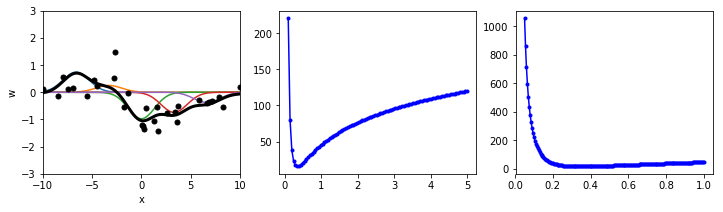

In [302]:
ns = 30
sgp = 50
ng = 5
nx = 201

x_range = np.array([-10., 10.])
x = np.linspace(-10, 10, nx)
span = x_range[1] - x_range[0]
intvl = span / (ng + 1)

lmd, wgt, sg = generate_nice_params(ng, intvl)
bases, bases_smp, grdtr, cntrs, xs, smp = generate_samples(ng, nx, ns, wgt, lmd, sg, x)
xs1 = np.vstack((np.ones(ns), xs))

plt.rcParams['figure.figsize'] = (12.0, 3.0)
plt.subplot(1,3,1)
plot_samples(x, wgt, bases, grdtr, xs, smp)
plt.xlim(x_range)
plt.ylim([-3., 3.])
plt.xlabel("x")
plt.ylabel("w")

s1 = 0.1
s2 = 5.0
sg_candid = np.linspace(s1, s2, 100)
sg_eval = evaluate_alp(bases_smp, smp, sgp, sg_candid)
plt.subplot(1,3,2)
plt.plot(sg_candid, sg_eval, 'b.-')

idx = np.where(sg_eval == sg_eval.min())[0][0]
sg_inf = sg_candid[idx]
print('rough scan : ', sg_inf)

s1 = 0.05
s2 = 1.0
plt.subplot(1,3,3)
sg_candid = np.linspace(s1, s2, 191)
sg_eval = evaluate_alp(bases_smp, smp, sgp, sg_candid)
plt.plot(sg_candid, sg_eval, 'b.-')

idx = np.where(sg_eval == sg_eval.min())[0][0]
sg_inf = sg_candid[idx]
print(' fine scan : ', sg_inf)

print("true  : sg = {0:1.4f} \ninfer : sg = {1:1.4f}".format(sg, sg_inf))
sge = sg_inf

$\alpha$ should be selected by maximum likelihood on the observed data.

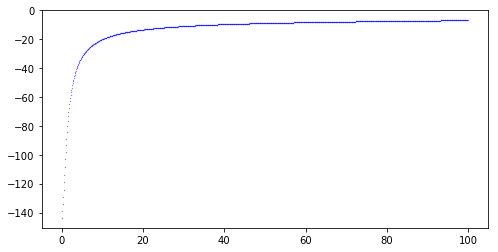

In [307]:
alps = np.arange(0.1, 100, 0.1)

aveloglk = np.zeros(alps.shape[0])
for i, alp in enumerate(alps):
    cova = (sgp**2) * kernel_rbf(xs1, xs1, alp) + (sge**2) * np.eye(ns)
    smp_logpdf = spst.multivariate_normal.logpdf(smp, np.zeros(ns), cova)
    aveloglk[i] = smp_logpdf.mean()

plt.rcParams['figure.figsize'] = (8.0, 4.0)
plt.plot(alps, aveloglk, 'b.', markersize=0.4)

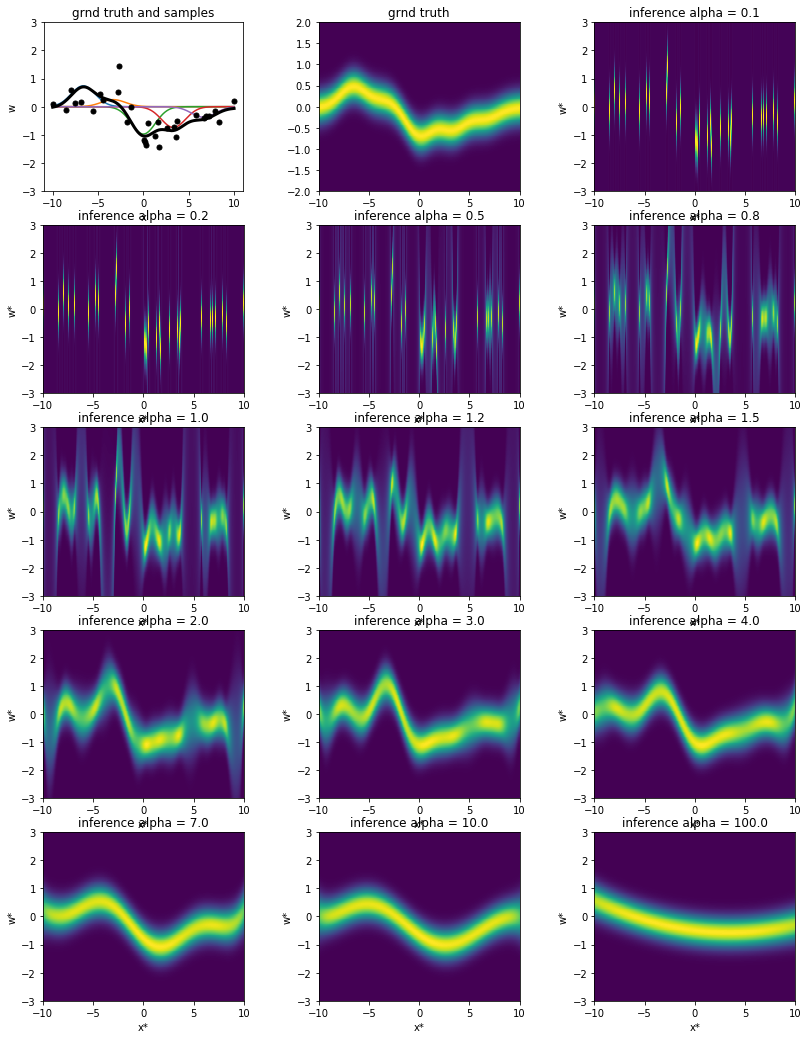

In [304]:
plt.rcParams['figure.figsize'] = (14.0, 18.0)

ax1 = plt.subplot(5,3,1)
plot_samples(x, wgt, bases, grdtr, xs, smp)
plt.ylim([-3., 3.])
plt.title('grnd truth and samples')
ax1.set_aspect(3.1)

ax2 = plt.subplot(5,3,2)
plot_lg_pdf(wgt, sg, cntrs, lmd, nx)
plt.title('grnd truth')
ax2.set_aspect(4.2)

ax = 2
alps = [0.1, 0.2, 0.5, 0.8, 1.0, 1.2, 1.5, 2.0, 3.0, 4.0, 7.0, 10.0, 100.0]
nres = nx
nn = nres**2
xres = np.linspace(-10, 10, nres)
yres = np.linspace(-3, 3, nres)
xg, yg = np.meshgrid(xres, yres)
xss = xg.reshape(1, nn)
yss = yg.reshape(1, nn)
xss1 = np.vstack((np.ones(nn), xss))

for alp in alps:
    ax += 1
    mu, cov = bayesian_inference(xss1, xs1, smp, sge, sgp, alp)
    brg_pdf = spst.norm.pdf(yss.squeeze(), mu.squeeze(), cov.squeeze()).reshape((nres, nres))
    brg_pdf = np.flipud(brg_pdf)
    ax3 = plt.subplot(5,3,ax)
    plt.imshow(brg_pdf, extent=[-10, 10, -3, 3])
    plt.title("inference alpha = {}".format(alp))
    plt.xlabel("x*")
    plt.ylabel("w*")
    ax3.set_aspect(2.8)